In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pycbc
from pycbc.types import FrequencySeries
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform

from gstlal import chirptime
from functools import partial


import h5py
import scipy

import bilby
from bilby.gw import utils as gwutils
from pesummary.gw.conversions import spins as pespin
from multiprocessing import Pool
import multiprocessing
from functools import partial
from bilby.gw import conversion

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:


def my_inner_product(hf1,hf2,det,flag):
    inner_prod_complex = gwutils.noise_weighted_inner_product(
                            aa=hf1[det.strain_data.frequency_mask],
                            bb=hf2[det.strain_data.frequency_mask],
                            power_spectral_density=det.power_spectral_density_array[det.strain_data.frequency_mask],
                            duration=det.strain_data.duration)

    #inner_prod_complex = det.inner_product_2(hf1, hf2)
    if flag == "c":
        return inner_prod_complex
    elif flag == "r":
        return np.real(inner_prod_complex)
    else:
        raise("Wrong flag!")


def get_dtdphi_withift_zeropad(h1,h2,det):

    psd = det.power_spectral_density_array
    f_array = det.frequency_array
    
    X_of_f = h1*h2.conjugate()/psd
    add_zero = np.zeros(int(63*len(X_of_f)))
    X_of_f = np.append(X_of_f,add_zero)
    X_of_t = np.fft.ifft(X_of_f)
    
    timelength = 1/(f_array[1]-f_array[0])
    t = np.linspace(-timelength/2,timelength/2,len(X_of_t))
    X_shifted = np.roll(X_of_t,len(X_of_t)//2)

    jmax = np.argmax( abs(X_shifted) )
    deltat = t[jmax]
    phase1 = 2*np.pi*f_array*deltat
    
    freq_mask = det.strain_data.frequency_mask
    inner_product = my_inner_product(h1.conjugate(), h2.conjugate()*np.exp(1j*phase1), det, 'c')
    
    '''
    gwutils.noise_weighted_inner_product(
                    aa=h1.conjugate()[freq_mask],
                    bb=(h2.conjugate()*np.exp(1j*phase1))[freq_mask],
                    power_spectral_density=det.power_spectral_density_array[freq_mask],
                    duration=det.strain_data.duration)'''
    
    deltaphi = -np.angle(inner_product)
    #phase2 = deltaphi
    
    return deltat,deltaphi


def get_shifted_h2_zeropad(h1,h2,det):
    '''
    Return the h2*exp(-i*phase_shift), i.e. h2* exp -i*(2\pi f \Delta t + \Delta \phi)
    '''
    deltat,deltaphi = get_dtdphi_withift_zeropad(h1,h2,det)
    f_array = det.frequency_array
    exp_phase = np.exp(-1j*(2*np.pi*f_array*deltat + deltaphi) )
    return h2*exp_phase

In [3]:
def make_FDaligned_waveforms(injection_parameters,
        duration, f_lower,sampling_frequency,
        approximant_list=['IMRPhenomPv2','SEOBNRv4P'],
        mode='plus'):
    ''' 
    Waveforms are aligned with the 1st model in approximant_list.
    '''
    ifos = bilby.gw.detector.InterferometerList(['L1'])
    det = ifos[0]
    det.duration = duration
    det.sampling_frequency=sampling_frequency
    det.frequency_mask = det.frequency_array>=f_lower
    mask = det.frequency_mask
    freq_array = det.frequency_array[mask]
    
    h_list = []
    
    if mode in ['plus', 'cross']:
        for i,approx in enumerate(approximant_list):
            waveform_arguments = dict(waveform_approximant=approx,
                              reference_frequency=50., minimum_frequency=20.)


            waveform_generator = bilby.gw.WaveformGenerator(
                duration=duration, sampling_frequency=sampling_frequency,
                frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
                parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
                waveform_arguments=waveform_arguments)


            h = waveform_generator.frequency_domain_strain(parameters=injection_parameters)[mode]
            if i==0:
                h_list.append(h)
            else:
                h = get_shifted_h2_zeropad(h_list[0],h,det)
                h_list.append(h)

        h_masked = []
        for h_to_mask in h_list:
            h_masked.append(h_to_mask[mask])

        return freq_array, h_masked
    
    
    elif mode == 'both':
        # h_list = [approx1_plus, approx1_cross, approx2_plus, approx2_cross, ...]
        for i,approx in enumerate(approximant_list):
            waveform_arguments = dict(waveform_approximant=approx,
                              reference_frequency=50., minimum_frequency=20.)


            waveform_generator = bilby.gw.WaveformGenerator(
                duration=duration, sampling_frequency=sampling_frequency,
                frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
                parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
                waveform_arguments=waveform_arguments)


            h = waveform_generator.frequency_domain_strain(parameters=injection_parameters)
            for j,m in enumerate(['plus', 'cross']):
                if i==0:
                    h_list.append(h[m])
                else:
                    hh = get_shifted_h2_zeropad(h_list[j],h[m],det)
                    h_list.append(hh)
        
        h_masked = []
        for h_to_mask in h_list:
            h_masked.append(h_to_mask[mask])

        return freq_array, h_masked

In [4]:
def amp_scaling(f, chirp_mass):
    '''
    Eq.4.34 of GW, for 1Mpc. Mc in unit of Msun
    '''
    c=299792458
    G=6.67e-11
    A=(np.pi)**(-2/3)*np.sqrt(5/24)

    amp = A*c*(G*chirp_mass/c**3)**(5/6) * f**(-7/6)
    
    return amp

def freq_scaling(f, chirp_mass):
    '''
    Eq.4.37 of GW
    '''
    #G=6.67e-11
    #c=299792458
    #A = 3/4 * (8*np.pi*G*chirp_mass/c**3)**(-5/3)
    return f**(-5/3) * 1e3
    
    
def scale_aligned_fdwaveforms(farray, h_list, chirp_mass):
    amp = amp_scaling(farray, chirp_mass)
    
    amp_scaled_h_list = []
    for h in h_list:
        amp_scaled_h_list.append(h / amp)
    
    scaled_f = freq_scaling(farray, chirp_mass)
    return scaled_f, amp_scaled_h_list

def unscale_scaled_fdwaveforms(farray_scaled, h_list_scaled, chirp_mass):
    '''
    Transform back to original waveforms.
    '''
    farray = (farray_scaled/1e3) ** (-3/5)
    
    amp = amp_scaling(farray, chirp_mass)
    
    h_list_unscaled = []
    for h in h_list_scaled:
        h_list_unscaled.append(h*amp)
    
    return farray, h_list_unscaled

def resample_scaled_fdwaveforms(farray_scaled, h_list_scaled):
    farray_scaled = farray_scaled[::-1]
    for i,h in enumerate(h_list_scaled):
        h_list_scaled[i] = h[::-1]
    
    fs_min = min(farray_scaled)
    fs_max = max(farray_scaled)
    new_fs = np.linspace(fs_min, fs_max, len(farray_scaled))
    
    h_list_scaled_resampled = []
    for h in h_list_scaled:
        interpolator = scipy.interpolate.CubicSpline(farray_scaled, h)
        new_h = interpolator(new_fs)
        h_list_scaled_resampled.append(new_h[::-1])
    
    return new_fs[::-1], h_list_scaled_resampled

# Test

In [13]:
injection_parameters = {'chirp_mass': 10.078761351651623,
 'mass_ratio': 0.8109404811445978,
 'a_1': 0.778817513918906,
 'a_2': 0.6618136183509149,
 'tilt_1': 1.5721118014736555,
 'tilt_2': 0.6209483780316792,
 'phi_12': 0.497541312882614,
 'phi_jl': 2.727769314864493,
 'theta_jn': 1.2076899194027677,
 'psi': 2.592123436585328,
 'phase': 3.153492039022807,
 'ra': 4.2400911,
 'dec': -0.39120439,
 'luminosity_distance': 430.76328,
 'geocent_time': 1256779567.5339382}

In [14]:
duration=32
f_lower=20
sampling_frequency=8192
approximant_list = ['IMRPhenomPv2','SEOBNRv4P']
freq_array, h_list = make_FDaligned_waveforms(injection_parameters,
        duration, f_lower, sampling_frequency,
        approximant_list=approximant_list)

freq_array_scaled, h_list_scaled = scale_aligned_fdwaveforms(freq_array, h_list, injection_parameters['chirp_mass'])
freq_array_unscaled, h_list_unscaled = unscale_scaled_fdwaveforms(freq_array_scaled, h_list_scaled, injection_parameters['chirp_mass'])


20:04 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
20:04 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


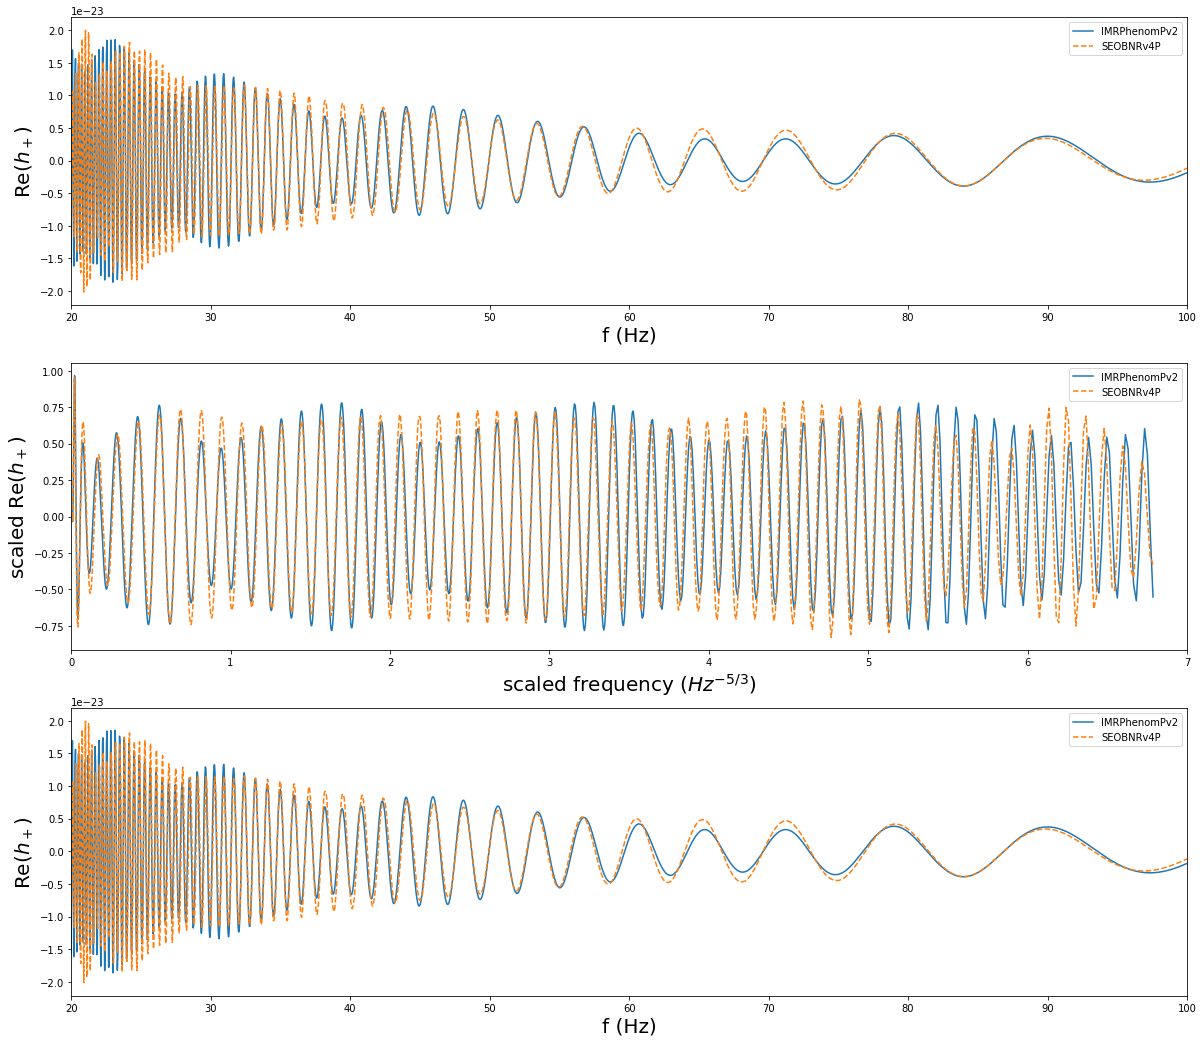

In [15]:

plt.figure(figsize=(20,18))

plt.subplot(3,1,1)
plt.plot(freq_array, np.real(h_list[0]), label=approximant_list[0])
plt.plot(freq_array, np.real(h_list[1]), label=approximant_list[1], linestyle='--')
plt.legend()
plt.xlim(20,100)
plt.xlabel('f (Hz)', fontsize=20)
plt.ylabel(r'Re($h_+$)', fontsize=20)


plt.subplot(3,1,2)
plt.plot(freq_array_scaled, np.real(h_list_scaled[0]), label=approximant_list[0])
plt.plot(freq_array_scaled, np.real(h_list_scaled[1]), label=approximant_list[1], linestyle='--')
plt.legend()
plt.xlabel(r'scaled frequency ($Hz^{-5/3}$)', fontsize=20)
plt.ylabel(r'scaled Re($h_+$)', fontsize=20)
plt.xlim(0,7)

plt.subplot(3,1,3)
plt.plot(freq_array_unscaled, np.real(h_list_unscaled[0]), label=approximant_list[0])
plt.plot(freq_array_unscaled, np.real(h_list_unscaled[1]), label=approximant_list[1], linestyle='--')
plt.legend()
plt.xlim(20,100)
plt.xlabel('f (Hz)', fontsize=20)
plt.ylabel(r'Re($h_+$)', fontsize=20)

plt.show()

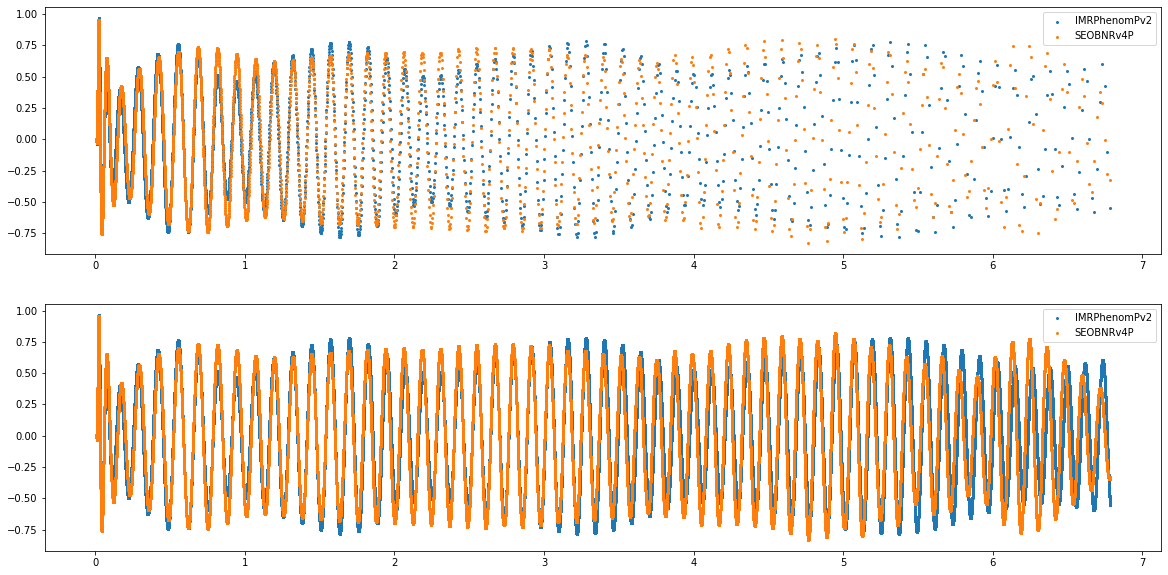

In [20]:
plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.scatter(freq_array_scaled, np.real(h_list_scaled[0]), label=approximant_list[0], s=4)
plt.scatter(freq_array_scaled, np.real(h_list_scaled[1]), label=approximant_list[1], s=4)
plt.legend()
#plt.xlim(0,0.1)

plt.subplot(2,1,2)
freq_array_scaled_resampled, h_list_scaled_resampled = resample_scaled_fdwaveforms(freq_array_scaled, h_list_scaled)
plt.scatter(freq_array_scaled_resampled, np.real(h_list_scaled_resampled[0]), label=approximant_list[0], s=4)
plt.scatter(freq_array_scaled_resampled, np.real(h_list_scaled_resampled[1]), label=approximant_list[1], s=4)
plt.legend()
#plt.xlim(0,0.1)

plt.show()

# Save

In [5]:
def generate_random_spin(Nsample, a_max=0.99):
    ''' 
    a random point in unit sphere
    (r,theta,phi) is the sphere coordinate
    '''
    r = np.random.random(Nsample) * a_max
    phi = 2*np.pi*np.random.random(Nsample)
    cos_theta = 2*np.random.random(Nsample)-1.0
    
    sin_theta = np.sqrt(1-cos_theta**2)
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    
    spin_x = r*sin_theta*cos_phi
    spin_y = r*sin_theta*sin_phi
    spin_z = r*cos_theta
    
    return spin_x, spin_y, spin_z


def generate_random_angle(Nsample, flag, low=0, high=2*np.pi):
    '''
    flag='cos' works for iota, whose cosine is uniform in [-1,1]
    flag='sin' works for dec, whose sine is uniform in [-1,1]
    flag='flat' works for psi (0-pi), phase (0-2pi), ra (0-2pi)
    '''
    if flag=="cos":
        cos_angle =  np.random.uniform(low=-1, high=1, size=Nsample)
        random_angle = np.arccos(cos_angle)
    elif flag=="sin":
        sindec = np.random.uniform(low=-1, high=1, size=Nsample)
        random_angle = np.arcsin(sindec)
    elif flag=="flat":
        random_angle = np.random.uniform(low=low, high=high, size=Nsample)

    return random_angle

def get_inj_paras(parameter_values,
                  parameter_names = ['chirp_mass','mass_ratio','a_1','a_2','tilt_1','tilt_2','phi_12','phi_jl',
                                     'theta_jn','psi','phase','ra','dec','luminosity_distance','geocent_time']):
    inj_paras = dict()
    for i, para_name in enumerate(parameter_names):
        inj_paras[para_name] = parameter_values[i]
    return inj_paras 

In [6]:
N=3
#q = np.logspace(np.log10(0.5),0,N)  # q from 0.5 to 1
q = np.linspace(0.5,1,N)

Mtot=60

mass_1 = Mtot/(1+q)
mass_2 = mass_1*q

mass_ratio = np.zeros(N) + q
chirp_mass = conversion.component_masses_to_chirp_mass(mass_1,mass_2)
    
spin1x,spin1y,spin1z = generate_random_spin(N, a_max=0.5)
spin2x,spin2y,spin2z = generate_random_spin(N, a_max=0.5)


iota = generate_random_angle(N, 'cos')
fref_list = np.zeros(N)+50.0
phiref_list = np.zeros(N)
converted_spin = pespin.spin_angles(mass_1,mass_2,iota , spin1x, spin1y, spin1z, spin2x, spin2y,spin2z, fref_list,phiref_list)
theta_jn = converted_spin[:,0]
phi_jl = converted_spin[:,1]
tilt_1 = converted_spin[:,2]
tilt_2 = converted_spin[:,3]
phi_12 = converted_spin[:,4]
a_1 = converted_spin[:,5]
a_2 = converted_spin[:,6]
        
        
luminosity_distance = np.ones(N)
phase = np.zeros(N)

# unimportant paras
geocent_time= np.zeros(N)
psi = np.zeros(N)
ra = np.zeros(N)
dec = np.zeros(N)


para_list = [chirp_mass,mass_ratio,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,
                theta_jn, psi, phase, ra, dec, luminosity_distance, geocent_time]

samples = np.zeros(shape=(N,len(para_list)) )

for i in range(len(para_list)):
    samples[:,i] = para_list[i] 

# inj_para = get_inj_paras(samples[0])

In [27]:
duration=32
f_lower=20
sampling_frequency=8192
approximant_list = ['IMRPhenomPv2','SEOBNRv4P']
n_approx = len(approximant_list)

data_dict = dict()

data_dict['frequency'] = dict()
data_dict['frequency']['frequency_array_original'] = []
data_dict['frequency']['frequency_array_scaled'] = []
data_dict['frequency']['frequency_array_scaled_resampled'] = []

data_dict['waveform_fd'] = dict()
for approx in approximant_list:
    data_dict['waveform_fd'][approx] = dict()
    data_dict['waveform_fd'][approx]['plus'] = dict()
    data_dict['waveform_fd'][approx]['cross'] = dict()
    for mode in ['plus', 'cross']:
        data_dict['waveform_fd'][approx][mode] = dict()
        data_dict['waveform_fd'][approx][mode]['original'] = []
        data_dict['waveform_fd'][approx][mode]['scaled'] = []
        data_dict['waveform_fd'][approx][mode]['scaled_resampled'] = []


data_dict['source_parameters'] = dict()
parameter_name_list = ['chirp_mass','mass_ratio','a_1','a_2','tilt_1','tilt_2','phi_12','phi_jl','theta_jn']
for paraname in parameter_name_list:
    data_dict['source_parameters'][paraname] = []
    
    

In [29]:
waveform_index = 0


for waveform_index in range(N):
    # calculation
    injection_para = get_inj_paras(samples[waveform_index])
    
    freq_array, h_list = make_FDaligned_waveforms(injection_para,
        duration, f_lower, sampling_frequency,
        approximant_list=approximant_list, mode='both')
    freq_array_scaled, h_list_scaled = scale_aligned_fdwaveforms(freq_array, h_list, injection_para['chirp_mass'])
    freq_array_scaled_resampled, h_list_scaled_resampled = resample_scaled_fdwaveforms(freq_array_scaled, h_list_scaled)
    
    
    # save to data_dic
    data_dict['frequency']['frequency_array_original'] = freq_array
    data_dict['frequency']['frequency_array_scaled'] = freq_array_scaled
    data_dict['frequency']['frequency_array_scaled_resampled'] = freq_array_scaled_resampled
    
    for approx_index,approx in enumerate(approximant_list):
        data_dict['waveform_fd'][approx]['plus']['original'].append(h_list[2*approx_index])
        data_dict['waveform_fd'][approx]['cross']['original'].append(h_list[2*approx_index+1])
        
        data_dict['waveform_fd'][approx]['plus']['scaled'].append(h_list_scaled[2*approx_index])
        data_dict['waveform_fd'][approx]['cross']['scaled'].append(h_list_scaled[2*approx_index+1])
        
        data_dict['waveform_fd'][approx]['plus']['scaled_resampled'].append(h_list_scaled_resampled[2*approx_index])
        data_dict['waveform_fd'][approx]['cross']['scaled_resampled'].append(h_list_scaled_resampled[2*approx_index+1])
    
    for paraname in parameter_name_list:
        data_dict['source_parameters'][paraname].append(injection_para[paraname])
        

20:16 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
20:16 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
20:16 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
20:16 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
20:17 bi

In [66]:
def save_dict_to_hdf5(dic, filename):
    """
    https://codereview.stackexchange.com/questions/120802/recursively-save-python-dictionaries-to-hdf5-files-using-h5py
    """
    with h5py.File(filename, 'w') as h5file:
        recursively_save_dict_contents_to_group(h5file, '/', dic)

def recursively_save_dict_contents_to_group(h5file, path, dic):
    """
    https://codereview.stackexchange.com/questions/120802/recursively-save-python-dictionaries-to-hdf5-files-using-h5py
    """
    for key, item in dic.items():
        if isinstance(item, (np.ndarray, np.int64, np.float64, str, bytes, list)):
            h5file[path + key] = item
        elif isinstance(item, dict):
            recursively_save_dict_contents_to_group(h5file, path + key + '/', item)
        else:
            raise ValueError('Cannot save %s type'%type(item))

def load_dict_from_hdf5(filename):
    """
    https://codereview.stackexchange.com/questions/120802/recursively-save-python-dictionaries-to-hdf5-files-using-h5py
    """
    with h5py.File(filename, 'r') as h5file:
        return recursively_load_dict_contents_from_group(h5file, '/')

def recursively_load_dict_contents_from_group(h5file, path):
    """
    https://codereview.stackexchange.com/questions/120802/recursively-save-python-dictionaries-to-hdf5-files-using-h5py
    """
    ans = {}
    for key, item in h5file[path].items():
        if isinstance(item, h5py._hl.dataset.Dataset):
            ans[key] = item[()]
        elif isinstance(item, h5py._hl.group.Group):
            ans[key] = recursively_load_dict_contents_from_group(h5file, path + key + '/')
    return ans



In [44]:
save_folder = ''
h5filename = save_folder + 'gw_fd_8D_2N2000_Pv2v4P.h5'

save_dict_to_hdf5(data_dict, h5filename)